In [52]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os , torch

from copy import deepcopy
from dataclasses import dataclass
from src.environ import DIR
# from src.algo.boost.lgbt import LgbtPlot , LgbtWeight
from typing import Any , ClassVar, Literal , Optional
from src.func import match_values, np_nanic_2d , np_nanrankic_2d

@dataclass
class BoosterData:
    raw_x   : pd.DataFrame | np.ndarray | torch.Tensor
    raw_y   : pd.Series    | np.ndarray | torch.Tensor
    secid   : Any = None
    date    : Any = None
    feature : Any = None
    weight_param : Optional[dict] = None

    df_var_sec  : ClassVar[list[str]] = ['SecID','instrument']
    df_var_date : ClassVar[list[str]] = ['TradeDate','datetime']

    def __post_init__(self):
        assert len(self.raw_x) == len(self.raw_y) , f'x and y length must match'
        if isinstance(self.raw_x , torch.Tensor) and isinstance(self.raw_y , torch.Tensor): 
            self.x = self.raw_x.detach().cpu().numpy()
            self.y = self.raw_y.detach().cpu().numpy()
        elif isinstance(self.raw_x , np.ndarray) and isinstance(self.raw_y , np.ndarray): 
            self.x = self.raw_x
            self.y = self.raw_y
        elif isinstance(self.raw_x , pd.DataFrame) and isinstance(self.raw_y , pd.Series): 
            self.var_sec  = [v for v in self.df_var_sec  if v in self.raw_x.index.names][0]
            self.var_date = [v for v in self.df_var_date if v in self.raw_x.index.names][0]
            x = self.raw_x.reset_index().set_index([self.var_sec,self.var_date])
            xarr = xr.Dataset.from_dataframe(x)
 
            xindex = [arr.values for arr in xarr.indexes.values()] + [list(xarr.data_vars)]
            self.x = np.stack([arr.to_numpy() for arr in xarr.data_vars.values()] , -1)
            if self.secid is None : self.secid = xindex[0]
            if self.date  is None : self.date  = xindex[1]
            if self.feature is None : self.feature = xindex[-1]

            yarr = xr.Dataset.from_dataframe(pd.DataFrame(self.raw_y.reset_index().set_index([self.var_sec,self.var_date])))
            self.y = np.stack([arr.to_numpy() for arr in yarr.data_vars.values()] , -1)
        else:
            raise TypeError(f'x and y type must match')
        if self.y.ndim == 3:
            assert self.y.shape[-1] == 1
            self.y = self.y[...,0]
        self.finite = np.isfinite(self.y)
        if self.secid is None : self.secid = np.arange(self.x.shape[0])
        if self.date  is None : self.date  = np.arange(self.x.shape[1])
        if self.feature is None : self.feature = np.array([f'feature.{i}' for i in range(self.x.shape[-1])])
        assert self.x.shape == (len(self.secid) , len(self.date) , len(self.feature))
        assert self.y.shape == (len(self.secid) , len(self.date))
        self.update_feature()
        if self.weight_param is None: self.weight_param = {'tau':0.75*np.log(0.5)/np.log(0.75) , 'ts_type':'lin' , 'rate':0.5}  

    def update_feature(self , use_feature = None):
        if use_feature is not None:
            assert all(np.isin(use_feature , self.feature)) , np.setdiff1d(use_feature , self.feature)
        self.use_feature = use_feature

    def lgbt_dataset(self , weight_param = None , reference = None):
        return lgb.Dataset(self.X() , self.Y() , weight = self.W(weight_param) , reference = reference)

    def X(self): 
        if self.use_feature is None:
            return self.x.reshape(-1,self.x.shape[-1])[self.finite.flatten()]
        else:
            return self.X_feat(self.use_feature).reshape(-1,len(self.use_feature))[self.finite.flatten()]

    def Y(self): return self.y.flatten()[self.finite.flatten()]

    def W(self , weight_param : Optional[dict] = None):
        weight_param = self.weight_param if weight_param is None else weight_param
        if weight_param is None: weight_param = {}
        w = self.calculate_weight(self.y , **weight_param)
        return w.flatten()[self.finite.flatten()]
    
    def X_feat(self , feature): return self.x[...,match_values(feature , self.feature)]

    def reform_pred(self , pred):
        new_pred = self.y.flatten()
        new_pred[self.finite.flatten()] = pred
        pred = new_pred.reshape(*self.y.shape)
        pred = np.array(pred)
        if isinstance(self.raw_y , pd.Series):
            pred = pd.DataFrame(pred , columns = self.date)
            pred[self.var_sec] = self.secid
            pred = pred.reset_index().melt(id_vars=self.var_sec,var_name=self.var_date)
            pred = pred.set_index([self.var_date,self.var_sec])['value'].loc[self.raw_y.index]
        elif isinstance(self.raw_y , np.ndarray):
            ...
        else:
            pred = torch.Tensor(pred)
        return pred

    @property
    def shape(self): return self.x.shape

    @property
    def nfeat(self): return len(self.feature) if self.use_feature is None else len(self.use_feature)
    
    @classmethod
    def calculate_weight(cls , y : np.ndarray, 
                         cs_type : Optional[Literal['top']] = 'top' ,
                         ts_type : Optional[Literal['lin' , 'exp']] = None ,
                         **kwargs):
        assert y.ndim == 2 or (y.ndim == 3 and y.shape[-1] == 1) , y.shape
        if y.ndim == 3: y = y[...,0]
        return cls.cs_weight(y , cs_type , **kwargs) * cls.ts_weight(y , ts_type , **kwargs)

    @classmethod
    def cs_weight(cls , y : np.ndarray , cs_type : Optional[Literal['top']] = 'top' , tau : Optional[float] = None , **kwargs):
        w = y * 0 + 1.
        if cs_type is None: return w
        if tau is None : tau = 0.75*np.log(0.5)/np.log(0.75)
        for j in range(w.shape[1]):
            if cs_type == 'top':
                v = y[:,j] * 1.
                v[~np.isnan(v)] = v[~np.isnan(v)].argsort()
                w[:,j] = np.exp((1 - v / np.nanmax(v))*np.log(0.5) / tau)
        return w
    
    @classmethod
    def ts_weight(cls , y : np.ndarray , ts_type : Optional[Literal['lin' , 'exp']] = 'lin' , rate : Optional[float] = None , **kwargs):
        w = y * 0 + 1.
        if ts_type is None: return w
        if rate is None : rate = 0.5
        if ts_type == 'lin':
            w *= np.linspace(rate,1,w.shape[1]).reshape(1,-1)
        elif ts_type == 'exp':
            w *= np.power(2 , -np.arange(w.shape[1])[::-1] / int(rate * w.shape[1])).reshape(1,-1)
        return w

class LgbtPlot:
    def __init__(self , lgb : Any) -> None:
        self.__lgbm = lgb

    @property
    def plot_path(self) -> str: return self.__lgbm.plot_path
    @property
    def evals_result(self) -> dict: return self.__lgbm.evals_result
    @property
    def model(self) -> lgb.Booster: return self.__lgbm.model
    @property
    def data(self) -> dict[str,BoosterData]: return self.__lgbm.data
    @property
    def train_param(self) -> dict: return self.__lgbm.train_param

    def training(self , show_plot = True , xlim = None , ylim = None , yscale = None):
        os.makedirs(self.plot_path, exist_ok=True)
        plt.figure()
        ax = lgb.plot_metric(self.evals_result, metric='l2')
        plt.scatter(self.model.best_iteration,list(self.evals_result['valid'].values())[0][self.model.best_iteration],label='best iteration')
        plt.legend()
        if xlim is not None: plt.xlim(xlim)
        if ylim is not None: plt.ylim(ylim)
        if yscale is not None: plt.yscale(yscale)
        if show_plot: plt.show()
        plt.savefig('/'.join([self.plot_path,'training_process.png']),dpi=1200)
        return ax
    
    def importance(self):
        os.makedirs(self.plot_path, exist_ok=True)
        lgb.plot_importance(self.model)
        plt.savefig('/'.join([self.plot_path,'feature_importance.png']),dpi=1200)

    def histogram(self , feature_idx='all'):
        os.makedirs(self.plot_path, exist_ok=True)
        if isinstance(feature_idx,str):
            assert feature_idx=='all'
            feature_idx = range(len(self.model.feature_name()))
        n_subplot = len(feature_idx)
        ncol = n_subplot if n_subplot < 5 else 5
        nrow = n_subplot // 5 + (1 if (n_subplot % 5 > 0) else 0)
        fig, axes = plt.subplots(nrow, ncol, figsize=(3*ncol, 3*nrow))
        if isinstance(axes , np.ndarray): 
            axes = axes.flatten()
        else:
            axes = [axes]
        for i in feature_idx:
            feature_importance = self.model.feature_importance()[i]
            if feature_importance ==0:
                axes[i].set_title(f'feature {self.model.feature_name()[i]} has 0 importance')
            else:
                lgb.plot_split_value_histogram(self.model, ax = axes[i] , feature=self.model.feature_name()[i], bins='auto' ,title="feature @feature@")
        fig.suptitle('split value histogram for feature(s)' , fontsize = 'x-large')
        plt.tight_layout()
        plt.savefig('/'.join([self.plot_path,'feature_histogram.png']),dpi=1200)

    def tree(self , num_trees_list=[0]):   
        os.makedirs(self.plot_path, exist_ok=True)
        for num_trees in num_trees_list:
            fig, ax = plt.subplots(figsize=(12,12))
            ax = lgb.plot_tree(self.model,tree_index=num_trees, ax=ax)
            plt.savefig('/'.join([self.plot_path , f'explainer_tree_{num_trees}.png']),dpi=1200)

    def shap(self , group='train'):
        import shap
        
        # 定义计算SHAP模型，这里使用TreeExplainer
        explainer = shap.TreeExplainer(self.model)
        X_df = deepcopy(self.data[group].X())
            
        # 计算全部因子SHAP
        shap_values = explainer.shap_values(X_df)
        os.makedirs('/'.join([self.plot_path , self.plot_path , 'explainer_shap']) ,exist_ok=True)
        for file in os.listdir('/'.join([self.plot_path , 'explainer_shap'])):
            os.remove('/'.join([self.plot_path , 'explainer_shap' , file]))
        
        # 全部特征SHAP柱状图
        shap.summary_plot(shap_values,X_df,plot_type='bar',title='|SHAP|',show=False)
        plt.savefig('/'.join([self.plot_path , 'explainer_shap' , 'explainer_shap_bar.png']) ,dpi=100,bbox_inches='tight')
        
        # 全部特征SHAP点图
        shap.summary_plot(shap_values,X_df,plot_type='dot',title='SHAP',show=False)
        plt.savefig('/'.join([self.plot_path , 'explainer_shap' , 'explainer_shap_dot.png']),dpi=100,bbox_inches='tight')
        
        # 单个特征SHAP点图
        
        for feature , imp in zip(self.model.feature_name() , self.model.feature_importance()):
            if imp == 0: continue
            shap.dependence_plot(feature,shap_values,X_df,interaction_index=None,title=f'SHAP of {feature}',show=False)
            plt.savefig('/'.join([self.plot_path , 'explainer_shap' , f'explainer_shap_dot_{feature}.png']),dpi=100,bbox_inches='tight')
    
    def sdt(self , group='train'):
        x = self.data[group].X()
        pred = self.model.predict(x)
        dtrain = lgb.Dataset(x, label=pred)
        _params = deepcopy(self.train_param)
        del _params['early_stopping']
        SDT = lgb.train(_params, dtrain, num_boost_round=1)
        fig, ax = plt.subplots(figsize=(12,12))
        ax = lgb.plot_tree(SDT, tree_index=0, ax=ax)
        plt.savefig('/'.join([self.plot_path,'explainer_sdt.png']),dpi=1200)

    def pdp(self , group='train'):
        os.makedirs('/'.join([self.plot_path , 'explainer_pdp']) , exist_ok=True)
        for file in os.listdir('/'.join([self.plot_path , 'explainer_pdp'])):
            os.remove('/'.join([self.plot_path , 'explainer_pdp' , file]))
        for feature , imp in zip(self.model.feature_name() , self.model.feature_importance()):
            if imp == 0: continue
            x = deepcopy(self.data[group].X())
            if isinstance(x , pd.DataFrame): x = x.values
            ifeat = match_values(feature , self.data[group].feature)
            # when calculating PDP，factor range is -5:0.2:5
            x_range = np.arange(np.floor(min(x[:,ifeat])), np.ceil(max(x[:,ifeat])), 0.2)
            
            # initialization and calculation
            pdp = np.zeros_like(x_range)
            for i, c in enumerate(x_range):
                x[:,ifeat] = c
                pdp[i] = np.array(self.model.predict(x)).mean()

            # plotPDP
            plt.figure()
            plt.plot(x_range,pdp)
            plt.title(f'PDP of {feature}')
            plt.xlabel(f'{feature}')
            plt.ylabel('y')
            plt.savefig('/'.join([self.plot_path , 'explainer_pdp' , f'explainer_pdp_{feature}.png']))
            plt.close()
    

In [53]:


class Lgbt():
    var_date = ['TradeDate','datetime'] 
    def __init__(self , 
                 train : Any = '../../data/tree_data/df_train.csv' , 
                 valid : Any = '../../data/tree_data/df_valid.csv' ,
                 test  : Any = '../../data/tree_data/df_test.csv' , 
                 feature = None , 
                 plot_path = '../../figures' ,
                 cuda = False , **kwargs):   
        self.train_param = {
            'objective': 'regression', 
            'verbosity': -1 , 
            'linear_tree': True, 
            'learning_rate': 0.3, 
            'lambda_l2': 1e-05, 
            'alpha': 1e-07, 
            'num_leaves': 31,
            'max_depth': 6, 
            # 'min_data_in_leaf' : 1, 
            'min_sum_hessian_in_leaf': 1, 
            'feature_fraction': 0.6, 
            'bagging_fraction': 0.75, 
            'force_col_wise': True, 
            'monotone_constraints': 1 , 
            'early_stopping' : 50 , 
            'zero_as_missing' : False ,
            'device_type': 'gpu' if cuda else 'cpu', # 'cuda' 'cpu'
            'seed': 42,
        }
        self.plot_path = plot_path
        self.train_param.update(kwargs)
        self.data_import(train , valid , test , feature)

    def data_import(self , train , valid , test , feature = None):
        assert type(train) == type(valid) == type(test) , f'type of train/valid/test must be identical'
        self.data : dict[str , BoosterData] = {}
        if isinstance(train , str):
            train = pd.read_csv(train,index_col=[0,1])
            valid = pd.read_csv(valid,index_col=[0,1])
            test  = pd.read_csv(test ,index_col=[0,1])
        assert train.shape[1] == valid.shape[1] == test.shape[1] , (train.shape[1] , valid.shape[1] , test.shape[1])
        if isinstance(train , pd.DataFrame) and isinstance(valid , pd.DataFrame) and isinstance(test , pd.DataFrame):
            assert type(train) == type(valid) == type(test) , f'type of train/valid/test must be identical'
            self.data['train'] = BoosterData(train.iloc[:,:-1] , train.iloc[:,-1] , feature = feature)
            self.data['valid'] = BoosterData(valid.iloc[:,:-1] , valid.iloc[:,-1] , feature = feature)
            self.data['test']  = BoosterData(test.iloc[:,:-1]  , test.iloc[:,-1]  , feature = feature)
        elif not (isinstance(train , pd.DataFrame) or isinstance(valid , pd.DataFrame) or isinstance(test , pd.DataFrame)):
            self.data['train'] = BoosterData(train[...,:-1] , train[...,-1] , feature = feature)
            self.data['valid'] = BoosterData(valid[...,:-1] , valid[...,-1] , feature = feature)
            self.data['test']  = BoosterData(test[...,:-1]  , test[...,-1]  , feature = feature)

    def setup(self , use_feature = None , weight_param = None):
        mono_constr = self.train_param['monotone_constraints']
        nfeat = len(use_feature) if use_feature else self.data['train'].nfeat
        if isinstance(mono_constr , list):
            if len(mono_constr) == 0: mono_constr = None
            elif len(mono_constr) != nfeat: mono_constr = (mono_constr * nfeat)[:nfeat]
        else:
            mono_constr = [mono_constr for _ in range(nfeat)]
        self.train_param['monotone_constraints'] = mono_constr
        
        [d.update_feature(use_feature) for d in self.data.values()]
        self.train_dataset = self.data['train'].lgbt_dataset(weight_param)
        self.valid_dataset = self.data['valid'].lgbt_dataset(weight_param , reference = self.train_dataset)

    def fit(self , use_feature = None , weight_param = None):
        self.setup(use_feature , weight_param)
        self.evals_result = dict()
        self.model = lgb.train(
            self.train_param ,
            self.train_dataset, 
            valid_sets=[self.train_dataset, self.valid_dataset], 
            valid_names=['train', 'valid'] , 
            num_boost_round=1000 , 
            callbacks=[lgb.record_evaluation(self.evals_result)],
        )
        
    def predict(self , inputs : Optional[BoosterData] = None , reform = True):
        if inputs is None: inputs = self.data['test']
        pred = self.model.predict(inputs.X())
        if reform: pred = inputs.reform_pred(pred)
        return pred
    
    def test_result(self):
        pred = np.array(self.predict(self.data['test'], reform = False)).reshape(*self.data['test'].y)
        df = self.calc_ic(pred , self.data['test'].y)
        plt.figure()
        df.cumsum().plot(title='average IC/RankIC = {:.4f}/{:.4f}'.format(*df.mean().values))
        plt.savefig('/'.join([self.plot_path,'test_prediction.png']),dpi=1200)
        return df
    
    def calc_ic(self , pred : np.ndarray , label : np.ndarray):
        if pred.ndim == 1: pred , label = pred.reshape(-1,1) , label.reshape(-1,1)
        ic = np_nanic_2d(pred , label , dim = 0)
        ric = np_nanrankic_2d(pred , label , dim = 0)
        return pd.DataFrame({'ic' : ic , 'rankic' : ric})
    
    @property
    def plot(self): return LgbtPlot(self)
    


In [1]:
import pandas as pd
import numpy as np
from src.algo.boost import lgbt

In [18]:

train = pd.read_csv(f'{DIR.data}/tree_data/df_train.csv' , index_col=[0,1])
valid = pd.read_csv(f'{DIR.data}/tree_data/df_valid.csv' , index_col=[0,1])
test  = pd.read_csv(f'{DIR.data}/tree_data/df_test.csv' , index_col=[0,1])


<Figure size 800x550 with 0 Axes>

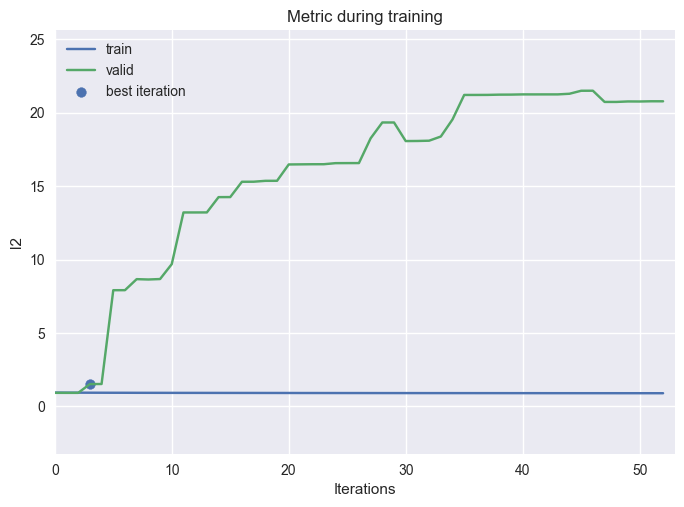

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

<Figure size 800x550 with 0 Axes>

In [54]:
a = lgbt.Lgbt(train = train , valid=valid , test=test)
a.fit()
a.plot.training()

<Figure size 800x550 with 0 Axes>

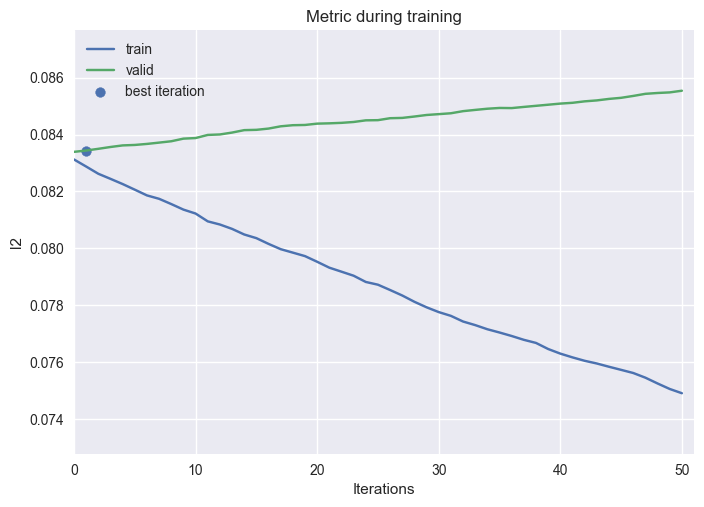

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

<Figure size 800x550 with 0 Axes>

In [2]:
def rand_nan(x , ratio = 0.1):
    ii = np.random.choice(np.arange(len(x)) , int(ratio * len(x)))
    x[ii] = np.nan
    return x

train = rand_nan(np.random.rand(1000,40,20))
valid = rand_nan(np.random.rand(500,40,20))
test  = rand_nan(np.random.rand(100,40,20))

a = lgbt.Lgbt(train = train , valid=valid , test=test)
a.fit()
a.plot.training()

In [3]:
pred = a.predict()
pred

array([[0.49981205, 0.49828202, 0.49981205, ..., 0.49912401, 0.49828202,
        0.49739197],
       [0.49739197, 0.49739197, 0.49981205, ..., 0.49739197, 0.49739197,
        0.49828202],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.49739197, 0.49981205, 0.46290864, ..., 0.50317562, 0.49981205,
        0.49981205],
       [0.49981205, 0.50317562, 0.50689805, ..., 0.4457725 , 0.49981205,
        0.497837  ],
       [0.50317562, 0.49739197, 0.49739197, ..., 0.49981205, 0.49981205,
        0.49981205]])

In [4]:
pred.shape

(100, 40)

In [4]:
import numpy as np

# 多个nX2的NumPy数组
arr1 = np.array([[1, 2], [3, 4], [5, 6]])
arr2 = np.array([[1, 2], [7, 8], [9, 10]])
arr3 = np.array([[11, 12], [13, 14], [15, 16]])

# 将多个数组组合成一个二维数组
combined_arr = np.vstack((arr1, arr2, arr3))

# 获取每一列的唯一值
unique_values = [np.unique(combined_arr[:, i]) for i in range(combined_arr.shape[1])]

# 打印每一列的唯一值
for i, column in enumerate(unique_values):
    print(f"Column {i+1} unique values:", column)


Column 1 unique values: [ 1  3  5  7  9 11 13 15]
Column 2 unique values: [ 2  4  6  8 10 12 14 16]


In [14]:
np.prod([1,2,3])

6

In [12]:
import numpy as np

# 创建一个NumPy数组
arr = np.array([3, 1, 2, 3, 1, 2 , 5])
a,b=np.unique(arr , return_inverse=True)

In [13]:
b

array([2, 0, 1, 2, 0, 1, 3], dtype=int64)

In [6]:
sorted_indices

array([1, 4, 2, 5, 0, 3], dtype=int64)